# Sun Spot Activity

In [1]:
import kaggle #api token file required
import os
import shutil
import zipfile
import pandas as pd
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
    !kaggle datasets download -d robervalt/sunspots

    local_zip = f'{os.getcwd()}\\data\\sunspots.zip'

    shutil.move(f'{os.getcwd()}\\sunspots.zip', local_zip)


  0%|          | 0.00/22.4k [00:00<?, ?B/s]
100%|##########| 22.4k/22.4k [00:00<00:00, 1.03MB/s]


'C:\\Users\\ChristianV700\\Documents\\GitHub\\Deeplearning.ai\\Tensorflow in Practice Specialization\\Course 4 Sequences, Time Series and Prediction\\Week 4\\data\\sunspots.zip'

In [4]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(f'{os.getcwd()}\\data')
zip_ref.close()

In [5]:
pd.read_csv(f'{os.getcwd()}\\data\\sunspots.csv')

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3247,3247,2019-08-31,0.5
3248,3248,2019-09-30,1.1
3249,3249,2019-10-31,0.4
3250,3250,2019-11-30,0.5


In [6]:
time_step = []
sunspots = []

with open(f'{os.getcwd()}\\data\\sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader) # the next() function skips the first line (header) when looping
  for row in reader:
    sunspots.append(float(row[2])) # sunspot value cast to float
    time_step.append(int(row[0])) # the index of the csv gets read into time_step variable

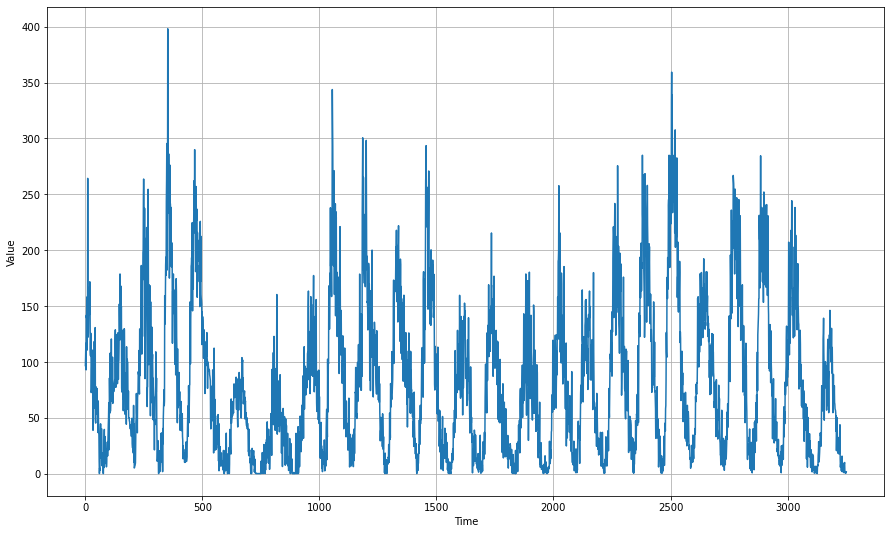

In [19]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(15, 9))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# the window size is important for training results
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Train for learning rate optimization

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


(1e-08, 0.0001, 0.0, 60.0)

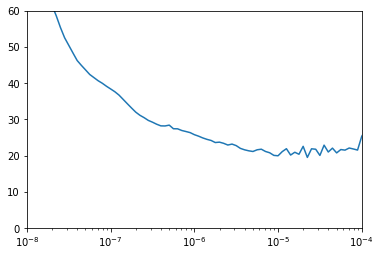

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

## Train with optimized learning rate

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  ])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=500, verbose=0)

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

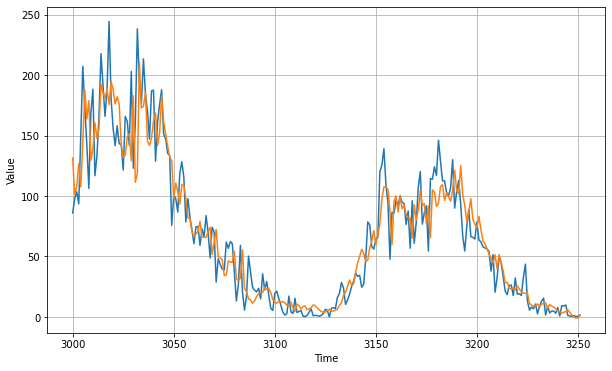

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
print('mae: ',tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

mae:  14.3005


<Figure size 432x288 with 0 Axes>

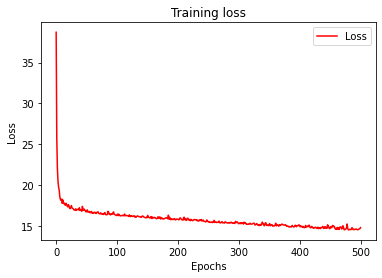

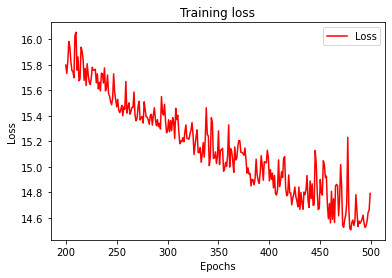

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [18]:
print(rnn_forecast)

[131.24907    101.25154    107.74949    126.5696     107.56209
 144.03062    187.47566    163.66043    178.78888    129.49646
 138.80525    160.49916    147.33786    155.72508    192.68405
 185.30348    180.8497     188.49838    175.61273    194.83052
 188.05283    176.13818    181.97739    176.03284    143.05396
 131.68192    133.74059    148.765      151.47234    129.13078
 182.95076    111.337006   119.00522    210.4722     172.85716
 174.1142     185.80109    145.39888    141.66734    147.928
 162.0406     168.64171    141.73595    152.10358    182.67801
 161.49338    151.14615    141.23593    132.16653    129.00371
  98.09076    110.61121    103.37031     93.36988    109.41858
 108.794716    97.68359     82.14757     81.20564     70.60156
  66.02433     68.707085    70.72976     79.09813     66.35095
  65.831345    65.71519     70.7888      74.04312     51.7025
  61.55957     72.31336     49.888958    48.738567    47.334766
  34.13172     34.84725     46.323387    45.370743    45.